<a href="https://colab.research.google.com/github/Ibrahimak555/GenerativeML/blob/main/GAN%20with%20Adaptive%20Discriminator%20Augmentation/GAN_with_AdaptiveDiscriminatorAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# data
num_epochs = 10  # train for 400 epochs for good results
image_size = 64
# resolution of Kernel Inception Distance measurement, see related section
kid_image_size = 75
padding = 0.25
dataset_name = "caltech_birds2011"

# adaptive discriminator augmentation
max_translation = 0.125
max_rotation = 0.125
max_zoom = 0.25
target_accuracy = 0.85
integration_steps = 1000

# architecture
noise_size = 64
depth = 4
width = 128
leaky_relu_slope = 0.2
dropout_rate = 0.4

# optimization
batch_size = 128
learning_rate = 2e-4
beta_1 = 0.5  # not using the default value of 0.9 is important
ema = 0.99

In [ ]:
def round_to_int(float_value):
    return tf.cast(tf.math.round(float_value), dtype=tf.int32)


def preprocess_image(data):
    # unnormalize bounding box coordinates
    height = tf.cast(tf.shape(data["image"])[0], dtype=tf.float32)
    width = tf.cast(tf.shape(data["image"])[1], dtype=tf.float32)
    bounding_box = data["bbox"] * tf.stack([height, width, height, width])

    # calculate center and length of longer side, add padding
    target_center_y = 0.5 * (bounding_box[0] + bounding_box[2])
    target_center_x = 0.5 * (bounding_box[1] + bounding_box[3])
    target_size = tf.maximum(
        (1.0 + padding) * (bounding_box[2] - bounding_box[0]),
        (1.0 + padding) * (bounding_box[3] - bounding_box[1]),
    )

    # modify crop size to fit into image
    target_height = tf.reduce_min(
        [target_size, 2.0 * target_center_y, 2.0 * (height - target_center_y)]
    )
    target_width = tf.reduce_min(
        [target_size, 2.0 * target_center_x, 2.0 * (width - target_center_x)]
    )

    # crop image
    image = tf.image.crop_to_bounding_box(
        data["image"],
        offset_height=round_to_int(target_center_y - 0.5 * target_height),
        offset_width=round_to_int(target_center_x - 0.5 * target_width),
        target_height=round_to_int(target_height),
        target_width=round_to_int(target_width),
    )

    # resize and clip
    # for image downsampling, area interpolation is the preferred method
    image = tf.image.resize(
        image, size=[image_size, image_size], method=tf.image.ResizeMethod.AREA
    )
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)


def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID calculation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


train_dataset = prepare_dataset("train")
val_dataset = prepare_dataset("test")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5994 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech_birds2011/0.1.1.incompleteDZ2U32/caltech_birds2011-train.tfrecord*…

Generating test examples...:   0%|          | 0/5794 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech_birds2011/0.1.1.incompleteDZ2U32/caltech_birds2011-test.tfrecord*.…

Dataset caltech_birds2011 downloaded and prepared to /root/tensorflow_datasets/caltech_birds2011/0.1.1. Subsequent calls will reuse this data.


In [ ]:
class KID(keras.metrics.Metric):
    def __init__(self, name="kid", **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean()

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                layers.InputLayer(input_shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()


In [ ]:
# "hard sigmoid", useful for binary accuracy calculation from logits
def step(values):
    # negative values -> 0.0, positive values -> 1.0
    return 0.5 * (1.0 + tf.sign(values))


# augments images with a probability that is dynamically updated during training
class AdaptiveAugmenter(keras.Model):
    def __init__(self):
        super().__init__()

        # stores the current probability of an image being augmented
        self.probability = tf.Variable(0.0)

        # the corresponding augmentation names from the paper are shown above each layer
        # the authors show (see figure 4), that the blitting and geometric augmentations
        # are the most helpful in the low-data regime
        self.augmenter = keras.Sequential(
            [
                layers.InputLayer(input_shape=(image_size, image_size, 3)),
                # blitting/x-flip:
                layers.RandomFlip("horizontal"),
                # blitting/integer translation:
                layers.RandomTranslation(
                    height_factor=max_translation,
                    width_factor=max_translation,
                    interpolation="nearest",
                ),
                # geometric/rotation:
                layers.RandomRotation(factor=max_rotation),
                # geometric/isotropic and anisotropic scaling:
                layers.RandomZoom(
                    height_factor=(-max_zoom, 0.0), width_factor=(-max_zoom, 0.0)
                ),
            ],
            name="adaptive_augmenter",
        )

    def call(self, images, training):
        if training:
            augmented_images = self.augmenter(images, training)

            # during training either the original or the augmented images are selected
            # based on self.probability
            augmentation_values = tf.random.uniform(
                shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
            )
            augmentation_bools = tf.math.less(augmentation_values, self.probability)

            images = tf.where(augmentation_bools, augmented_images, images)
        return images

    def update(self, real_logits):
        current_accuracy = tf.reduce_mean(step(real_logits))

        # the augmentation probability is updated based on the discriminator's
        # accuracy on real images
        accuracy_error = current_accuracy - target_accuracy
        self.probability.assign(
            tf.clip_by_value(
                self.probability + accuracy_error / integration_steps, 0.0, 1.0
            )
        )


In [ ]:
# DCGAN generator
def get_generator():
    noise_input = keras.Input(shape=(noise_size,))
    x = layers.Dense(4 * 4 * width, use_bias=False)(noise_input)
    x = layers.BatchNormalization(scale=False)(x)
    x = layers.ReLU()(x)
    x = layers.Reshape(target_shape=(4, 4, width))(x)
    for _ in range(depth - 1):
        x = layers.Conv2DTranspose(
            width, kernel_size=4, strides=2, padding="same", use_bias=False,
        )(x)
        x = layers.BatchNormalization(scale=False)(x)
        x = layers.ReLU()(x)
    image_output = layers.Conv2DTranspose(
        3, kernel_size=4, strides=2, padding="same", activation="sigmoid",
    )(x)

    return keras.Model(noise_input, image_output, name="generator")


# DCGAN discriminator
def get_discriminator():
    image_input = keras.Input(shape=(image_size, image_size, 3))
    x = image_input
    for _ in range(depth):
        x = layers.Conv2D(
            width, kernel_size=4, strides=2, padding="same", use_bias=False,
        )(x)
        x = layers.BatchNormalization(scale=False)(x)
        x = layers.LeakyReLU(alpha=leaky_relu_slope)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    output_score = layers.Dense(1)(x)

    return keras.Model(image_input, output_score, name="discriminator")


In [ ]:

class GAN_ADA(keras.Model):
    def __init__(self):
        super().__init__()

        self.augmenter = AdaptiveAugmenter()
        self.generator = get_generator()
        self.ema_generator = keras.models.clone_model(self.generator)
        self.discriminator = get_discriminator()

        self.generator.summary()
        self.discriminator.summary()

    def compile(self, generator_optimizer, discriminator_optimizer, **kwargs):
        super().compile(**kwargs)

        # separate optimizers for the two networks
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

        self.generator_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.discriminator_loss_tracker = keras.metrics.Mean(name="d_loss")
        self.real_accuracy = keras.metrics.BinaryAccuracy(name="real_acc")
        self.generated_accuracy = keras.metrics.BinaryAccuracy(name="gen_acc")
        self.augmentation_probability_tracker = keras.metrics.Mean(name="aug_p")
        self.kid = KID()

    @property
    def metrics(self):
        return [
            self.generator_loss_tracker,
            self.discriminator_loss_tracker,
            self.real_accuracy,
            self.generated_accuracy,
            self.augmentation_probability_tracker,
            self.kid,
        ]

    def generate(self, batch_size, training):
        latent_samples = tf.random.normal(shape=(batch_size, noise_size))
        # use ema_generator during inference
        if training:
            generated_images = self.generator(latent_samples, training)
        else:
            generated_images = self.ema_generator(latent_samples, training)
        return generated_images

    def adversarial_loss(self, real_logits, generated_logits):
        # this is usually called the non-saturating GAN loss

        real_labels = tf.ones(shape=(batch_size, 1))
        generated_labels = tf.zeros(shape=(batch_size, 1))

        # the generator tries to produce images that the discriminator considers as real
        generator_loss = keras.losses.binary_crossentropy(
            real_labels, generated_logits, from_logits=True
        )
        # the discriminator tries to determine if images are real or generated
        discriminator_loss = keras.losses.binary_crossentropy(
            tf.concat([real_labels, generated_labels], axis=0),
            tf.concat([real_logits, generated_logits], axis=0),
            from_logits=True,
        )

        return tf.reduce_mean(generator_loss), tf.reduce_mean(discriminator_loss)

    def train_step(self, real_images):
        real_images = self.augmenter(real_images, training=True)

        # use persistent gradient tape because gradients will be calculated twice
        with tf.GradientTape(persistent=True) as tape:
            generated_images = self.generate(batch_size, training=True)
            # gradient is calculated through the image augmentation
            generated_images = self.augmenter(generated_images, training=True)

            # separate forward passes for the real and generated images, meaning
            # that batch normalization is applied separately
            real_logits = self.discriminator(real_images, training=True)
            generated_logits = self.discriminator(generated_images, training=True)

            generator_loss, discriminator_loss = self.adversarial_loss(
                real_logits, generated_logits
            )

        # calculate gradients and update weights
        generator_gradients = tape.gradient(
            generator_loss, self.generator.trainable_weights
        )
        discriminator_gradients = tape.gradient(
            discriminator_loss, self.discriminator.trainable_weights
        )
        self.generator_optimizer.apply_gradients(
            zip(generator_gradients, self.generator.trainable_weights)
        )
        self.discriminator_optimizer.apply_gradients(
            zip(discriminator_gradients, self.discriminator.trainable_weights)
        )

        # update the augmentation probability based on the discriminator's performance
        self.augmenter.update(real_logits)

        self.generator_loss_tracker.update_state(generator_loss)
        self.discriminator_loss_tracker.update_state(discriminator_loss)
        self.real_accuracy.update_state(1.0, step(real_logits))
        self.generated_accuracy.update_state(0.0, step(generated_logits))
        self.augmentation_probability_tracker.update_state(self.augmenter.probability)

        # track the exponential moving average of the generator's weights to decrease
        # variance in the generation quality
        for weight, ema_weight in zip(
            self.generator.weights, self.ema_generator.weights
        ):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, real_images):
        generated_images = self.generate(batch_size, training=False)

        self.kid.update_state(real_images, generated_images)

        # only KID is measured during the evaluation phase for computational efficiency
        return {self.kid.name: self.kid.result()}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6, interval=5):
        # plot random generated images for visual evaluation of generation quality
        if epoch is None or (epoch + 1) % interval == 0:
            num_images = num_rows * num_cols
            generated_images = self.generate(num_images, training=False)

            plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
            for row in range(num_rows):
                for col in range(num_cols):
                    index = row * num_cols + col
                    plt.subplot(num_rows, num_cols, index + 1)
                    plt.imshow(generated_images[index])
                    plt.axis("off")
            plt.tight_layout()
            plt.show()
            plt.close()


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense (Dense)               (None, 2048)              131072    
                                                                 
 batch_normalization (Batch  (None, 2048)              6144      
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         262144    
 anspose)                                                

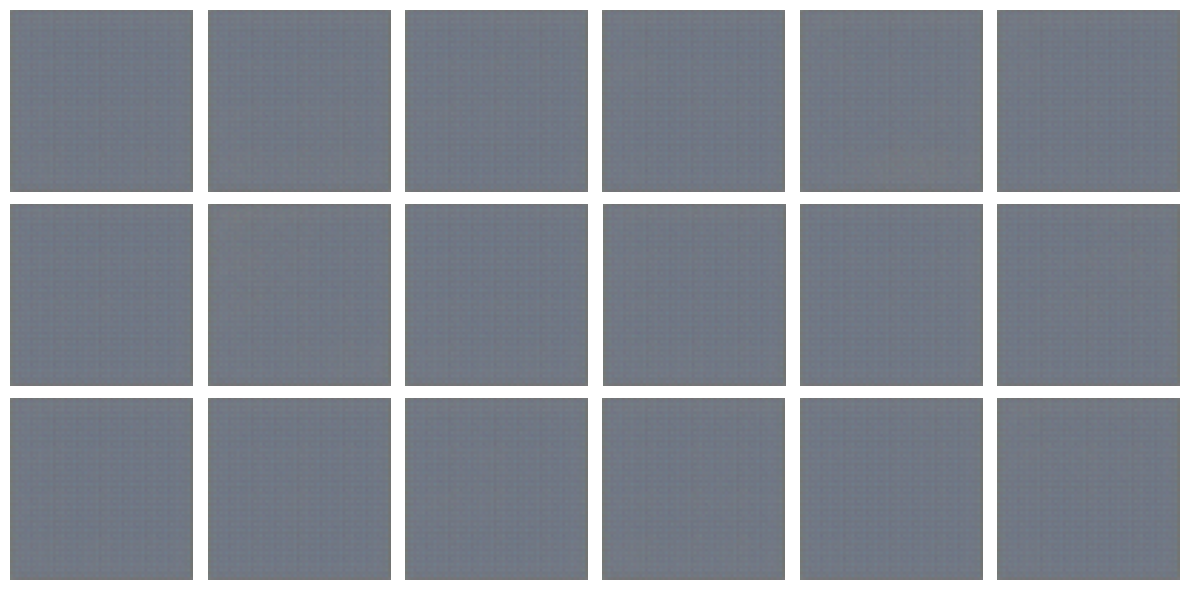

46/46 [==============================] - 11s 248ms/step - g_loss: 4.1041 - d_loss: 0.0656 - real_acc: 0.9822 - gen_acc: 0.9920 - aug_p: 0.0231 - val_kid: 6.4088
Epoch 6/10
46/46 [==============================] - 10s 216ms/step - g_loss: 5.3357 - d_loss: 0.1199 - real_acc: 0.9630 - gen_acc: 0.9708 - aug_p: 0.0290 - val_kid: 5.2955
Epoch 7/10
46/46 [==============================] - 9s 199ms/step - g_loss: 4.2542 - d_loss: 0.1140 - real_acc: 0.9587 - gen_acc: 0.9679 - aug_p: 0.0340 - val_kid: 6.3767
Epoch 8/10
46/46 [==============================] - 10s 222ms/step - g_loss: 3.9702 - d_loss: 0.1273 - real_acc: 0.9490 - gen_acc: 0.9647 - aug_p: 0.0383 - val_kid: 3.5021
Epoch 9/10
46/46 [==============================] - 10s 214ms/step - g_loss: 4.0775 - d_loss: 0.2170 - real_acc: 0.9190 - gen_acc: 0.9280 - aug_p: 0.0422 - val_kid: 3.1403
Epoch 10/10
46/46 [==============================] - ETA: 0s - g_loss: 3.6122 - d_loss: 0.2416 - real_acc: 0.9103 - gen_acc: 0.9212 - aug_p: 0.0453

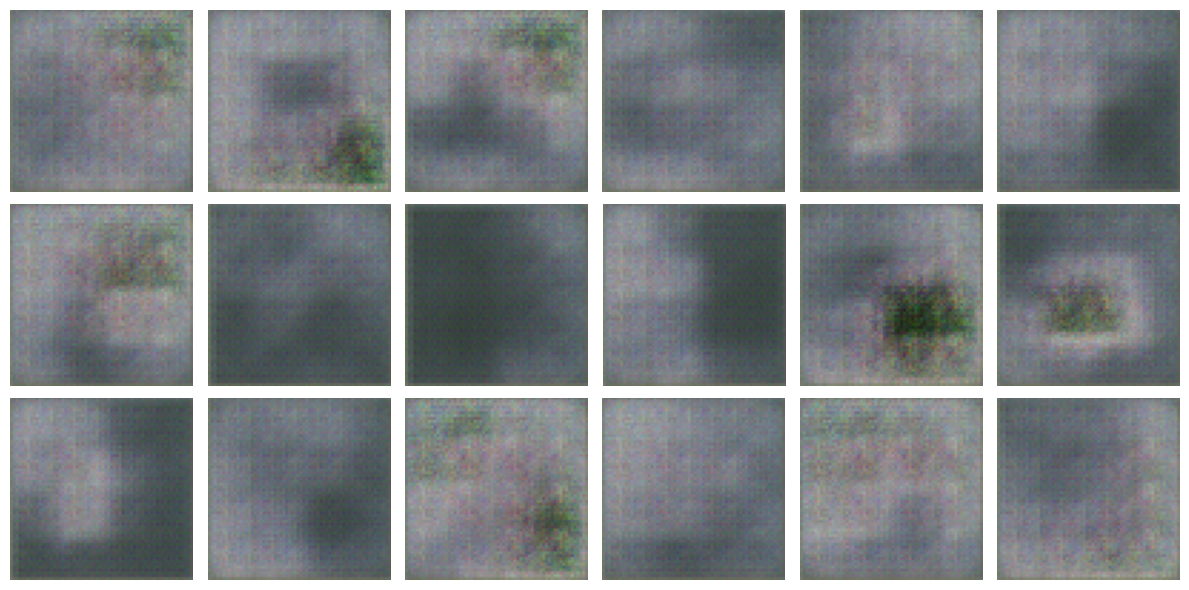

46/46 [==============================] - 11s 248ms/step - g_loss: 3.6122 - d_loss: 0.2416 - real_acc: 0.9103 - gen_acc: 0.9212 - aug_p: 0.0453 - val_kid: 2.7675


In [ ]:
# create and compile the model
model = GAN_ADA()
model.compile(
    generator_optimizer=keras.optimizers.Adam(learning_rate, beta_1),
    discriminator_optimizer=keras.optimizers.Adam(learning_rate, beta_1),
)

# save the best model based on the validation KID metric
checkpoint_path = "gan_model"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

# run training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)

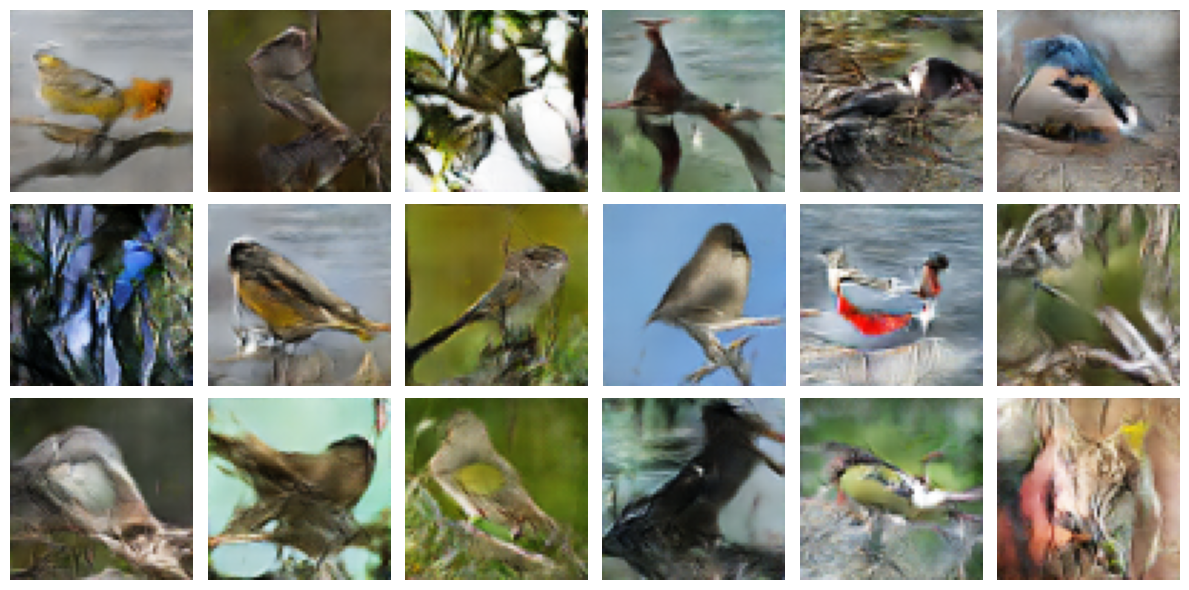

In [ ]:
# load the best model and generate images
model.load_weights(checkpoint_path)
model.plot_images()